   <img src="http://localhost/dashboard/images/evrl_logo.JPG" align="left"width="130" height="130" />   <h1 align ="center"> Social Data Analytics Tweet Classifier</h1>

                                           ##Centered Project Summary
.
### *Goals*
   - Accurately Classify Tweets from sql
### *Tasks*          
   - Build Html front end
   - Optimize feaurelists 
   - Adapt to run predictions in parallel
   - Upload Determined Category to SQL
   - Pull New Tweets from stream 
   - Build live Visualization

## **The PullLocalData function takes the tweets from a local sql server and prepares the data                                                  for use in the classifiers**##
- *rlabels*:Controls wether the output labels are strings or integers
- *tup*:Controls wether the output is a single tuple or 2 lists
 1.
### Changes to be made:
    - Find a way to evalute the text on links provided

In [100]:
def PullLocalData(rlabels=0,tup=0):
    import pymysql 
    import numpy as np
    from collections import namedtuple
    
    labs=["Violent Crimes","Arrests Made","Community Activities","Missing Persons"\
          ,"Victim of Crimes","Humanizing","DBP Campaigns","Other"]#The possiple catergories for a tweet 

    db=pymysql.connect(host="localhost", user="root", passwd="toor", db="soda")
    tex=db.cursor(pymysql.cursors.DictCursor)
    #sql query takes tweets ID content and category  
    tex.execute("SELECT tweets_table.tweets_key,tweets_table.content, category_table.category_1 FROM tweets_table,category_table WHERE tweets_table.tweets_key=category_table.tweets_key;")
    mex=tex.fetchall()
    #reads text data into tuple
    tweet = []
    raw = namedtuple('Tweet', 'words tags hashtags')
    for w in mex[:len(mex)]:
        words=normalize_tweet(str(w.get('content'))).split()
        hashtags=[]
        tags= w.get('category_1') if rlabels==0 else labs[((w.get('category_1'))-1)]
        if len(re.findall("\#\S+",str(w.get('content')))) > 0:
            hashtags.append(re.findall("\#\S+",str(w.get('content'))))
            
        if len(words)>=2:   tweet.append(raw(words,tags,hashtags))#removes any tweet with less than three words
    #reads text data into two seperate lists
    if tup==0 and rlabels==0:
        x=[]
        y=[]
        for i in range(len(tweet)):
            x.append(tweet[i].words)
            y.append(tweet[i].tags)
        y=np.array(y)
        y=y.astype('int64').reshape(-1)
    return ((x,y) if tup==0 else tweet)

**Used to remove special character,links, and stopwords from data**
### Changes to be made:
   - Include and Weight Hashtags and Sender 
   - Remove less informative words from mako file

In [135]:
def normalize_tweet(text):
    import re 
    import string
    htag=re.compile('\#\S+')
    at_re = re.compile(r'\@[^\s]*')
    text=re.sub(htag,'',text,14)
    remove_spl_char_regex = re.compile('[%s]' % re.escape(string.punctuation)) # regex to remove special characters
    text = re.sub(at_re, '',text)
    stopwords=[u'rt', u're', u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u'not', u'only', u'own', u'same', u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just', u'don', u'should', u'now']
    tokens = []
   
    text=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # to replace url with ''
    text = remove_spl_char_regex.sub(" ",text)  # Remove special characters
    text=text.lower()
    for word in text.split():
        if word not in stopwords \
            and word not in string.punctuation \
            and len(word)>1 \
            and word != '``':
                tokens.append(word)
    return str(" ".join(tokens))

## **Used to create feautures for every tweet**
   - Can be passed either a list of tuples or a string object



In [ ]:
import numpy as np
u=np.load('mako')
u=u.reshape(1)
u=u[0]
keywords=u
def extract_features(document):
    if type(document) is (list):
        fet=[]
        for i in range(len(document)):
            document_words = set(document[i].words)
            features = {}
            for word in keywords:
                features['contains(%s)' % word] = (word in document_words)
            fet.append([features,document[i].tags])
        return fet
    elif (type(document) is str):
        document_words = set(document.split())
        features = {}
        for word in keywords:
            features['contains(%s)' % word] = (word in document_words)
        return features

# Major Changes Needed
   - Feature list is 5604 words. Shrink this to increase accuracy and speed

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score as acc
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
X,Y=(PullLocalData())
X=(list(map(lambda x:"".join(X[x]),range(len(X)))))
t=3
T2=[]
Bcc=[] #An array holding the accuracy over every iteration
print("Making Predictions...")
while t==3:
    X1, C, Y2, U = train_test_split(X, Y, test_size=(t/10), random_state=42)
    
    text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('ovr',LinearSVC())])
    text_clf = text_clf.fit(X,Y)
    
    P=text_clf.predict(C)
    T2.append(t/10)
    t-=1
    Bcc.append(acc(U,P))
    

Making Predictions...


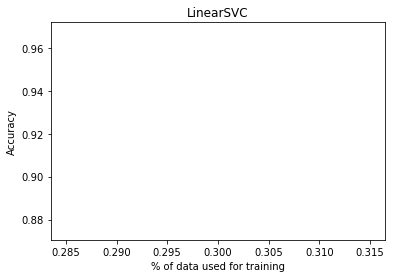

In [149]:
#Previously used to plot accuracy on various data sizes
%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure(1)
#plt.subplot(211)
#plt.plot(T,Acc)
#plt.xlabel(r"% of data used for training")
#plt.ylabel("Accuracy")
#plt.title("NLTK.GaussianNaiveBayes")

#plt.subplot(212)
plt.plot(T2,Bcc)
plt.xlabel(r"% of data used for training")
plt.ylabel("Accuracy")
plt.title("LinearSVC")
plt.show()

#plt.subplot(312)
#plt.plot(T3,Ccc)
#plt.xlabel(r"% of data used for training")
#plt.ylabel("Accuracy")
#plt.title("OneVsRest")
plt.show()
